# Part of Speech Tagging and Word Sense Disambiguation using a Hidden Markov Model (HMM)

Chapters 9 and 10 of the book are all about Hidden Markov Models (HMM). Ultimately they are probabilistic models of states, given certain observations. The idea is that you have states, _initial_ _probabilities_ for being in those states, and _transition_ _probabilities_ for transitioning from one state to another. The "hidden" portion of the Markov Model is that the "true states" are actually hidden normally, e.g., sometimes you can't directly measure if it's Sunny, or Rainy, but you may indirectly have the temperature as a measurement of the true or "hidden" state. Those measurements that you _do_ have are called _emissions_ and the final portion of an HMM is the probabilities that you are in the true hidden state S1...SN, given that you have a set of _emission_ _probabilities_ E1....EN for emission states 1...N.

The book walks us through constructing an HMM example of Rainy, or Sunny, with observable emission states 'walk', 'shop' and 'clean'. In [Listing 9.1-9.6](../ch09/Listing%209.1-9.6.ipynb), I cover how to walk through the HMM step by step. The first example of the HMM is to compute the likelihood of observing a sequence of emission events, given the initial probabilities, transition probabilities and emission probabilities. The example is [from Wikipedia](https://en.wikipedia.org/wiki/Hidden_Markov_model#A_concrete_example). The Listing 9.1-9.6 notebook I provided walks through unfolding to learn more about how the HMM is actually doing the comuptation in this simple weather example. Basically in the first iteration to initialize, the HMM takes the first observation index, 0, aka 'walk' and multiplies the probabilities of walking when it is raining / sunny times by the initial probabilities of it being rainy or sunny to get a composite probability for it being rainy or sunny and having walked. Then the next step steps through the rest of the observations, 'shopping', 'shopping', 'cleaning', 'shopping', and does the following

   1. for 'shopping', it takes the emission probability of seeing shopping in each state at that point, and multiplies it by the existing forward model, then applies the weighted transition probabilities in each actual state (Rainy or Sunny), through multiplication, and then accumulates them (through reduce_sum) to get the cumulitative probability of being in either state given the observations thus far ('walk', 'shopping')
   2. it does the same thing for the next observations, 'shopping', 'cleaning' and 'shopping' to get the cumultative probability of being in either state
   3. the final answer is the cumultation of either probability, so the likelihood of that sequence of events happening, but not necessarily the highest probability state you are in

After we go through the HMM, we then focus on the Viterbi algorithm (yes, _that_ [Andrew Viterbi](https://viterbischool.usc.edu/about-andrew-viterbi/)). The algorithm runs through the HMM, but keeps back propogation state, so that it can tell us the most likely hidden states, given the observations (or emissions) that we have seen. This is like keeping a map of the cumulative probabilities of being in Rainy, or Sunny, given the emissions you have seen so far - kind of like I described above. The second example in Chapter 9, [Listing 9.7-9.11](../ch09/Listing%209.7-9.11.ipynb), re-runs the Rainy/Sunny example, this time recommending the actual hidden states that you were in, given the observations.

This is all to prepare us for the final chapter exercise which makes up Chapter 10, a new one in this version of the book. Use an HMM to model something. Most of the links in the book didn't work (e.g., the [Gait example](http://mng.bz/Tqfx) is a 1TB (movie?) download that you have to [fax something in for](http://www.cse.usf.edu/~sarkar/SudeepSarkar/Gait_Data.html)...._ummm no_). Finally, though, the end of chapter introduces something that we can actually do: use an HMM to model Part of Speech (PoS). This is basically the process of taking in a sentence, and tagging it appropriately with its parts of speech. I believe the book expected us to use the actual words of a sentence as the emission states, and the hidden states be the PoS tags, instead, after doing some research about the [Gutenberg corpus](http://www.gutenberg.org/cache/epub/3203/pg3203.txt) that it recommends in the book, I stumbled across [this page](http://wiki.apertium.org/wiki/Part-of-speech_tagging) about the [Apertium Machine Translation platform](https://www.apertium.org/). That page is all about using HMMs for PoS disambiguation. The basic idea is that even after PoS tagging (and I even noticed this by creating a function for PoS tagging using Gutenberg, which is basically a list of 200K+ words, with multiple PoS classes like Adjective, Noun, Pronoun, etc.) all language has ambiguity. A great example is `engineer`. In English, it can be both a `Noun` and a `Verb`. The Apertium tagger has to handle these ambiguities in a PoS tagging scenario. Consider two sentences:

```
I love being an engineer and working at NASA JPL!
I am hoping to engineer a future Mars rover vehicle!
```

And the results of e.g., a PoS tagger without the capability for _disambiguation_ of a word's _sense_ or _word sense disambiguation_.

```
I<Noun/> love<Adverb/> being<Verb/> an engineer<Noun/><Verb/> and<Conjunction/> at<Preposition/> NASA<Noun/> JPL<Noun/>.
I<Noun/> am<Adverb/> hoping<Verb/> to engineer<Noun/><Verb/> a future Mars<Noun/> rover<Noun/> vehicle<Noun/>.
```

In the above two sentences, engineer is tagged as a Noun and a Verb by a PoS tagger that cannot deal with word sense disambiguation. So, the example for Apertium shows how its PoS tagger using HMMs to disambiguate. I thought this was a fantastic example, and it showed me basically how to construct the transition, emission, and initial probabilities. 
See below:

![Apertium-p1](../../figs/ch10-apertium-p1.png)
![Apertium-p2](../../figs/ch10-apertium-p2.png?)

You basically need 3 parallel corpora to start.

   1. A list of sentences, for me, I recorded five of my own sample sentences from sayings around the house that hopefully you get a kick out of.
   2. A list of analyzed sentences from the original `morphological analysis` which is the process of running a PoS tagger that can't disambiguate yet. These should contain `ambiguity classes` that you need to disambiguate with their proper PoS tag.
   3. A parallel tagged corpora that matches the analyzed sentences, expect instead of ambiguity, it has the proper tag that should be applied. 
   
The jist of the algorithms to construct the matrices is as follows:

   1. Transition Matrix: We are creating a bi-gram model, so you take all the PoS that Gutenberg can handle, ~14 tags, along with adding the 'sent' tag to it as the row names, and then for each column. Then you look at the tagged corpora, and count how many times each bi-gram pair occurs in which the row(first PoS tag) is followed by the second word (PoS) tag. We then divide the counts in each row by the total sum of all counts in that row. In essence this computes the ratio, or probability that e.g., Noun, will be followed by Verb compared to all of the other tags that follow Noun, or the `strength` of that particular transition. The resultant matrix is the transition probabilities e.g., from one hidden state, the PoS tag, to another.
   2. Emission Matrix: For this matrix, we take all of the ambiguity classes, e.g., `<Noun/><Verb/>`, where it can't decide, and they become initial rows of the matrix, followed by the actual regular PoS class tags. The columns of the matrix are the PoS class tags. What we are computing in this matrix is the amount of times for each column PoS tag from the tagged corpus appears, whereas in the analyzed corpus, we see an ambiguity class instead. We then divide each of these counts by the total amount of times that PoS tag for the column appears in the tagged corpus. This gives us the `emission probability` for seeing an ambiguity class, instead of the correct PoS tag. Then, for the regular PoS tag classes, if it appears in the tagged corpus, and the analyzed corpus at least once, we write a 1 in the corresponding PoS tag col,row cell. 
   3. Initial probabilities: these are essentially the row in the Transition Matrix corresponding to the sent tag. In essence, it's the probabilities to move from a sentence end to the start of the next word in the corpus, or the probability that each word starts a sentence in the corpus. 
   
Using those 3 algorithms, we can generate the needed input for the HMM to disambiguate word sense in PoS tags. I ended up learning tons about [Pandas](http://pandas.pydata.org/) Data Frames, which was very useful. I applied them and wrote the functions necessary, and then refactored them heavily. After going through my small 5 sentence example and seeing that I didn't have enough evidence really to help do the disambiguation (it performed pretty poorly only disambiguating one of the words correctly in my test), I decided to use [NLTK](http://nltk.org/) [Test Corpora](https://www.nltk.org/book/ch02.html) and the Brown corpus. I picked a random Brown file (`ch07`) that contained 133 sentences. Then, I had to write code to convert/translate between [NLTK's universal char tag set](https://github.com/slavpetrov/universal-pos-tags) and the Gutenberg set. So, I created a mapping between them of a subset of tags, and wrote a bunch of code to clean the data between them so that we could tag Gutenberg as an analyzer, and then use the NLTK tagged corpora for ground truth. 

I ended up getting it working after forever, and at the end of the day, my HMM PoS tagger is around <b>~79%</b> accurate, which isn't bad!

Here are the best references I found along the way!


# References

   0. [Apertium PoS HMM PoS Tagging](http://wiki.apertium.org/wiki/Part-of-speech_tagging) - the motivation for this whole assignment for me.
   1. [Categorizing and Tagging Words](https://www.nltk.org/book/ch05.html) = NLTK information about its tagged corpora and how to access them.
   2. [Accessing Text Corpora and Lexical Resources](https://www.nltk.org/book/ch02.html) - different NLTK corpora. 
   3. [Conditionally Updating Dataframes in Pandas](https://stackoverflow.com/questions/18196203/how-to-conditionally-update-dataframe-column-in-pandas) - how to conditionally update dataframes in Pandas. 
   4. [Sum across a Pandas Row and then Divide all Cells by Sum](https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value) - useful for computing transition matrix and then dividing. 
   5. [Using truth value from Pandas series](https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o) - needed to only select Pandas cells with a particular value.
   6. [Swap Axes in Pandas](https://stackoverflow.com/questions/16301546/swapping-axes-in-pandas) - needed b/c the emission matrix axes needed to be swapped.
   7. [NLTK PoS Tagging](https://www.cs.bgu.ac.il/~elhadad/nlp17/NLTKPOSTagging.html) - useful info about NLTK tagging.
   8. [Paper on PoS Disambiguation](https://www.aclweb.org/anthology/E99-1018) - from ACL conference.
   


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import nltk
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('brown')
nltk.download('universal_tagset')
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg, brown
from nltk.tag.util import untag

[nltk_data] Downloading package punkt to /Users/mattmann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/mattmann/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package brown to /Users/mattmann/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/mattmann/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
pos_tags = {
    "N" : "Noun",
    "p" : "Plural",
    "h" : "Noun Phrase",
    "V" : "Verb (usu participle)",
    "t" : "Verb (transitive)",
    "i" : "Verb (intransitive)",
    "A" : "Adjective",
    "v" : "Adverb",
    "C" : "Conjunction",
    "P" : "Preposition",
    "!" : "Interjection",
    "r" : "Pronoun",
    "D" : "Definite Article",
    "I" : "Indefinite Article",
    "o" : "Nominative"
    
}

pos_headers = pos_tags.keys()
pos_tag_counts = {}
pos_words = {}
end_of_sent_punc = [".", "?", "!"]

In [3]:
pt_vals = [*pos_tags.values()]
pt_vals += ["sent"] # add this b/c it will be the initial probability row

In [4]:
[*pt_vals]

['Noun',
 'Plural',
 'Noun Phrase',
 'Verb (usu participle)',
 'Verb (transitive)',
 'Verb (intransitive)',
 'Adjective',
 'Adverb',
 'Conjunction',
 'Preposition',
 'Interjection',
 'Pronoun',
 'Definite Article',
 'Indefinite Article',
 'Nominative',
 'sent']

In [5]:
univ_tagset = {
    "ADJ"     : "Adjective",
    "ADP"     : "Adposition", 
    "ADV"     : "Adverb",
    "CONJ"    : "Conjunction",
    "DET"     : "Determiner",
    "NOUN"    : "Noun",
    "NUM"     : "Numeral",
    "PRT"     : "Particle",
    "PRON"    : "Pronoun",
    "VERB"    : "Verb",
    "."       : "Punctuation marks",
    "X"       : "Other"
}

univ_gutenberg_map = {
    "ADJ"  : "A",
    "ADV"  : "v",
    "CONJ" : "C",
    "NOUN" : "N",
    "PRON" : "r",
    "VERB" : "V",
    "."    : "sent"
}

univ_gutenberg_map_r = {v: k for k, v in univ_gutenberg_map.items()}

In [6]:
class HMM(object):
    def __init__(self, initial_prob, trans_prob, obs_prob):
        self.N = np.size(initial_prob)
        self.initial_prob = initial_prob
        self.trans_prob = trans_prob
        self.emission = obs_prob
        assert self.initial_prob.shape == (self.N, 1)
        assert self.trans_prob.shape == (self.N, self.N)
        assert obs_prob.shape[0] == self.N
        self.obs_idx = 0
        self.fwd = tf.cast(0., tf.double)
        self.viterbi = None
        
    def get_emission(self, obs_idx):
        slice_location = [0, obs_idx]
        num_rows = tf.shape(self.emission)[0]
        slice_shape = [num_rows, 1]
        return tf.slice(self.emission, slice_location, slice_shape)
    
    def forward_init_op(self, obs_idx):
        self.obs_idx = obs_idx
        obs_prob = self.get_emission(self.obs_idx)
        fwd = tf.multiply(self.initial_prob, obs_prob)
        return fwd
    
    def forward_op(self, obs_idx, fwd):
        self.obs_idx = obs_idx
        self.fwd = fwd
        transitions = tf.matmul(self.fwd,
        tf.transpose(self.get_emission(self.obs_idx)))
        weighted_transitions = transitions * self.trans_prob
        fwd = tf.reduce_sum(weighted_transitions, 0)
        return tf.reshape(fwd, tf.shape(self.fwd))
        
    def decode_op(self, obs_idx, viterbi):
        self.viterbi = viterbi
        self.obs_idx = obs_idx
        transitions = tf.matmul(viterbi,
        tf.transpose(self.get_emission(self.obs_idx)))
        weighted_transitions = transitions * self.trans_prob
        viterbi = tf.reduce_max(weighted_transitions, 0)
        return tf.reshape(viterbi, tf.shape(self.viterbi))

    def backpt_op(self, viterbi):
        back_transitions = tf.matmul(self.viterbi, np.ones((1, self.N)))
        weighted_back_transitions = back_transitions * self.trans_prob
        return tf.argmax(weighted_back_transitions, 0)     

In [7]:
def forward_algorithm(sess, hmm, observations):
    fwd = hmm.forward_init_op(observations[0])
    for t in range(1, len(observations)):
        fwd = hmm.forward_op(observations[t],fwd)
    prob = tf.reduce_sum(fwd)
    return prob

In [8]:
def viterbi_decode(hmm, observations):
    viterbi = hmm.forward_init_op(observations[0])
    backpts = np.ones((hmm.N, len(observations)), 'int32') * -1
    for t in range(1, len(observations)):
        viterbi = hmm.decode_op(observations[t], viterbi)
        backpt = hmm.backpt_op(viterbi)        
        backpts[:, t] = backpt
        
    tokens = [tf.math.argmax(viterbi[:, -1], 0)]
    for i in range(len(observations) - 1, 0, -1):
        tokens.append(backpts[tokens[-1], i])
    return tokens[::-1]

In [9]:
def sent_to_obs(emission_df, pos_df, a_all_tags, sent_num):
    obs = []
    sent = pos_df['Untagged'][sent_num]
    #print("Sentence is "+sent)
    tags = a_all_tags[sent_num]
    #print("Tags are: "+str(tags))
    for t in tags:
        idx = str(t)
        #print("Looking for index for "+idx)
        obs.append(int(emission_df.loc[emission_df.FirstPoS==idx].index[0]))
    return obs
        

In [10]:
def seq_to_pos(seq):
    tags = []
    for s in seq:
        tags.append(pt_vals[s])
    
    return tags
        

In [11]:
def parse_pos_file(pos_file):
    with open(pos_file, 'r') as pf:
        ftext = pf.readlines()
        for line in tqdm(ftext):
            l_split = line.split('\\')
            word = l_split[0]
            #print("w: "+word)            
            classes=[]
            u_classes = l_split[1].strip()
            for i in range(0, len(u_classes)):
                if not u_classes[i] in pos_tags:
                    print("Unknown pos tag: "+u_classes[i]+" from line "+line)
                    continue
                classes.append(u_classes[i])
            
            #print("C: "+str(classes))
            pos_words[word] = classes
            for c in classes:
                if c in pos_tag_counts:
                    cnt = pos_tag_counts[c]
                    cnt = cnt + 1
                else:
                    cnt = 1
                pos_tag_counts[c] = cnt

In [12]:
def build_pos_df(untagged, analyzed, tagged):
    pos_df = pd.DataFrame(columns=['Untagged', 'Analyzed', 'Tagged'])
    for i in range(0, len(untagged)):
        pos_df = pos_df.append({"Untagged":untagged[i], "Analyzed":analyzed[i], "Tagged": tagged[i]}, ignore_index=True)
    
    return pos_df

In [13]:
#morphological analysis using gutenberg http://www.gutenberg.org/cache/epub/3203/pg3203.txt
#white list is allowable set of tags that gutenberg and universal tag set both recognize
#tagged_sent is the set of actual tags from a truth set for this sentence
def analyse(txt, white_list=None, tagged_sent=None):
    map_tags = {
        "ADP" : "ADJ",
        "DET" : "CONJ",
        "NUM" : "NOUN",
        "PRT" : "CONJ"
    }
    words = word_tokenize(txt)
    words_and_tags = []
    wl_keys = None
    if white_list != None:
        wl_keys = white_list.keys()
        white_list_r = {v: k for k, v in white_list.items()}
        wlr_keys = white_list_r.keys()
        
    for i in range(0, len(words)):
        w = words[i]
        w_and_tag = w
        if w in pos_words:
            for c in pos_words[w]:
                if wl_keys != None:
                    if c not in wl_keys:
                        print("PoS Tag: ["+c+"] not in white list: "+str(wl_keys)+" for word: ["+w+"]")
                        continue # skip this 
                    else:
                        print("PoS Tag: ["+c+"] is in white list: "+str(wl_keys)+" for word: ["+w+"]")
                        
                    if tagged_sent != None:
                        if tagged_sent[i][1] in white_list_r:
                            ttag = white_list_r[tagged_sent[i][1]]
                            if ttag != "sent":
                                if ttag in pos_words[w]:
                                    w_and_tag += "<"+pos_tags[ttag]+"/>"
                                else:
                                    print("Tagged corpus tag: ["+ttag+"] disagrees with label set: ["+str(pos_words[w])+"], picking "+pos_tags[c])
                                    w_and_tag += "<"+pos_tags[c]+"/>"
                            else:
                                if tagged_sent[i][0] == ".":
                                    w_and_tag += "<"+ttag+"/>"

                            break
                        else:
                            # this is the case where we have a tagged annotation that doesn't correspond 
                            # from NLTK/brown/etc to its Gutenberg ambiguity 
                            mt = map_tags[tagged_sent[i][1]]
                            ttag = white_list_r[mt]
                            print("Grount truth: ["+tagged_sent[i][1]+"] does not correspond to white list: ["+str(wlr_keys)+"] for word: ["+w+"], using ["+mt+"]")
                            if ttag in pos_words[w]:
                                w_and_tag += "<"+pos_tags[ttag]+"/>"
                            else:
                                print("Tagged corpus tag: ["+ttag+"] disagrees with label set: ["+str(pos_words[w])+"], picking "+pos_tags[c])
                                w_and_tag += "<"+pos_tags[c]+"/>"                            

                            break

                    else:
                        w_and_tag = w_and_tag + "<" + pos_tags[c] + "/>"
                else:
                    w_and_tag = w_and_tag + "<" + pos_tags[c] + "/>"
                    
        elif w in end_of_sent_punc:
            w_and_tag = w_and_tag + "<sent/>"

        words_and_tags.append(w_and_tag)
    return " ".join(words_and_tags)

In [14]:
def compute_tags(df_col):
    all_tags = []
    
    for row in df_col:
        tags = []
        tag = None
        tag_list = None
        
        for i in range(0, len(row)): 
           # print(row[i])
            
            if row[i] == "<":
                tag = ""
            elif i+1 < len(row) and row[i] == "/" and row[i+1] == ">":
                
                # do we just add it as a regular tag or do we make a new list
                # and add it
                #print("tag is "+tag)
                
                if i+2 < len(row) and row[i+2] == "<":
                    if tag_list == None:
                        tag_list = []
                        
                    tag_list.append(tag)
                    tag = None
                else:
                    if tag_list != None and len(tag_list) > 0:
                        #print("here: tag list is "+str(tag_list))
                        tag_list.append(tag)
                        #print("now tag list is "+str(tag_list))
                        tags.append(tag_list)
                        #print("Tags for this sentence: "+str(tags))
                        tag_list = None
                        tag = None
                    else:
                        tags.append(tag)
                        #print("Tags for this sentence: "+str(tags))
                        tag = None
                        
            else:
                if tag != None:
                    tag = tag + row[i]
          
        #print("TAGS: "+str(tags))
        all_tags.append(tags)
        tags = None
        tag = None
        tag_list = None
        
    return all_tags
    
       
                


In [15]:
def build_trans(pt_vals):
    trans_df = pd.DataFrame(columns=["FirstPoS"] + pt_vals)
    trans_df.set_index('FirstPoS')
    for i in range(0, len(pt_vals)):
        pt_data = {}
        pt_data["FirstPoS"] = pt_vals[i]
        for j in range(0, len(pt_vals)):
            pt = pt_vals[j]
            pt_data[pt] = 0        
        trans_df = trans_df.append(pt_data, ignore_index=True)
    
    return trans_df

In [16]:
def compute_trans_matrix(t_df, tags):

    #print("TAGS: "+str(tags))
    for j in range(0, len(pos_df['Tagged'])):
        s = pos_df['Tagged'][j]
        #print("new sentence")

        tt_idx = []
        #print("About to iterate tags")
        for i in range(0, len(tags[j])):  
            tt_idx.append(tags[j][i])
            #print("TAG: "+tags[j][i]+": LEN: "+str(len(tt_idx)))
            
            if j > 0 and i == 0:
                row_idx = "sent"
                col_idx = tags[j][i]
                cnt = t_df.loc[t_df.FirstPoS==row_idx, col_idx]
                cnt = cnt + 1    
                #print("Updated count for ("+row_idx+","+col_idx+") is "+str(cnt))
                t_df.loc[t_df.FirstPoS==row_idx, col_idx] = cnt                                  
                
                
            if len(tt_idx) == 2:
                row_idx = tt_idx[0]
                col_idx = tt_idx[1]
                #print("Row Index: "+row_idx+", Col Index: "+col_idx)
                cnt = t_df.loc[t_df.FirstPoS==row_idx, col_idx]
                #print("Existing count is "+str(cnt))
                cnt = cnt + 1
                #print("Updated count for ("+row_idx+","+col_idx+") is "+str(cnt))
                t_df.loc[t_df.FirstPoS==row_idx, col_idx] = cnt                     
                tt_idx.clear()
            elif len(tt_idx) == 1 and tags[j][i] == "sent":
                row_idx = tags[j][i-1]
                col_idx = tags[j][i]
                cnt = t_df.loc[t_df.FirstPoS==row_idx, col_idx]
                cnt = cnt + 1
                #print("Updated count for ("+row_idx+","+col_idx+") is "+str(cnt))
                t_df.loc[t_df.FirstPoS==row_idx, col_idx] = cnt                     
                tt_idx.clear()


In [17]:
# algorithm for computing the emission matrix (use j, k)
# for each row j in tagged corpus tags
# for each tag k, find the corresponding tag in the analyzed corpus tags
# if the corresponding tag is the same, add +1 to the count at emission_df[tagk, tagk], and make sure it is only 1 in other words, add 1 only if count = 0
# if the corresponding tag is an ambiguity class, add +1 to the count at emission_df[tagk, analyzed_tags[k]]
# after the sums are computed, for each ambiguity class row, divide it by the max number of times the col k appeared in the tagged corpus

In [18]:
def build_emission(pt_vals, a_all_tags):
    emission_df = pd.DataFrame(columns=["FirstPoS"] + pt_vals)
    emission_df.set_index('FirstPoS')

    # add amb classes
    amb_classes = {}
    for r in a_all_tags:
        for t in r:
            if type(t) == list:
                am_class = str(t)
                if not am_class in amb_classes:
                    amb_classes[am_class] = "yes"

    amb_classes_k = sorted(amb_classes.keys())

    for ambck in amb_classes_k:
        em_data = {}
        em_data["FirstPoS"] = ambck
        for j in range(0, len(pt_vals)):
            em = pt_vals[j]
            em_data[em] = 0   
        emission_df = emission_df.append(em_data, ignore_index=True)


    for i in range(0, len(pt_vals)):
        em_data = {}
        em_data["FirstPoS"] = pt_vals[i]
        for j in range(0, len(pt_vals)):
            em = pt_vals[j]
            em_data[em] = 0        
        emission_df = emission_df.append(em_data, ignore_index=True)
        
    return (emission_df, amb_classes_k)

In [19]:
def compute_emission(e_df, t_tags, a_tags):
    for j in range(0, len(t_tags)):
        print("TAGS for s ["+str(j)+"]: "+str(t_tags[j]))
        
        for i in range(0, len(t_tags[j])):
            a_tag = a_tags[j][i]
            t_tag = t_tags[j][i]
            
            if type(a_tag) == list:
                a_tag_str = str(a_tag)
                row_idx = a_tag_str
                col_idx = t_tag
                cnt = e_df.loc[e_df.FirstPoS==row_idx, col_idx]
                cnt = cnt + 1
                print("Updated count for ("+row_idx+","+col_idx+") is "+str(cnt))
                e_df.loc[e_df.FirstPoS==row_idx, col_idx] = cnt
            else:
                if a_tag != t_tag:
                    print("This should never happen, the tags don't agree and it's not an ambiguity class. a_tag: ["+a_tag+"]: t_tag: ["+t_tag+"]")
                else:
                    row_idx = a_tag
                    col_idx = t_tag
                    cnt = e_df.loc[e_df.FirstPoS==row_idx, col_idx]
                    print("CNT: "+str(cnt))
                    if (cnt < 1).bool():
                        cnt = cnt + 1
                        print("Updated count for ("+row_idx+","+col_idx+") is "+str(cnt))
                        e_df.loc[e_df.FirstPoS==row_idx, col_idx] = cnt  
                    else:
                        print("Skipping updating count for ("+row_idx+","+col_idx+")")
                

In [20]:
def count_tagged(tags):
    tag_counts = {}
    cnt = 0
    for i in range(0, len(tags)):
        row = tags[i]
        print("ROW "+str(i)+": num tagged words: "+str(len(row)))
        for t in row:
            if type(t) == list:
                print("TAG "+str(t)+" is a list, size: "+str(len(t)))
                for tt in t:
                    if tt in tag_counts:
                        cnt = tag_counts[tt]
                        cnt = cnt + 1
                        tag_counts[tt] = cnt
                    else:
                        tag_counts[tt] = 1
            else:
                if t in tag_counts:
                    cnt = tag_counts[t]
                    cnt = cnt + 1
                    tag_counts[t] = cnt
                    print("TAG not a list, adding 1 to count: ["+str(tag_counts[t])+"] for tag "+t)
                else:
                    tag_counts[t] = 1
                    print("TAG not a list, first seen, count 1: for tag "+t)
    
    return tag_counts

In [21]:
def emission_div_by_tag_counts(emission_df, amb_classes_k, tag_counts):
    for pt in pt_vals:
        for ambck in amb_classes_k:
            row_idx = str(ambck)
            col_idx = pt

            if pt in tag_counts:
                tcnt = tag_counts[pt]
                if tcnt > 0:
                    print("Updating ("+row_idx+","+col_idx+") and dividing its value by "+str(tcnt))
                    emission_df.loc[emission_df.FirstPoS==row_idx, col_idx] = emission_df.loc[emission_df.FirstPoS==row_idx, col_idx] / tcnt


In [22]:
def intersection(lst1, lst2): 
    return set(lst1).symmetric_difference(set(lst2))

In [24]:
parse_pos_file('../../data/mobypos.txt')

Unknown pos tag: e from line cowardic\Ne




[('Interjection', 433), ('Adjective', 50473), ('Conjunction', 93), ('Definite Article', 103), ('Noun', 111321), ('Preposition', 162), ('Verb (usu participle)', 11791), ('Noun Phrase', 34308), ('Verb (intransitive)', 5141), ('Plural', 8556), ('Pronoun', 117), ('Verb (transitive)', 16266), ('Adverb', 13398)]


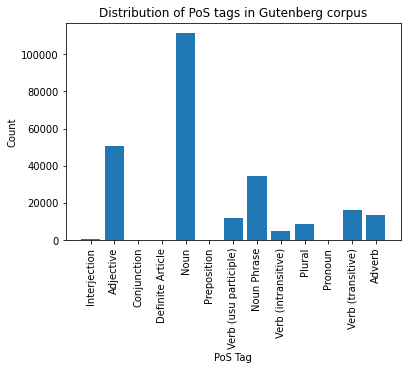

In [25]:
pos_lists = sorted(pos_tag_counts.items()) # sorted by key, return a list of tuples
plists = []
for i in range(0, len(pos_lists)):
    t = pos_lists[i]
    plists.append((pos_tags[t[0]], t[1]))

print(plists)
x, y = zip(*plists) # unpack a list of pairs into two tuples
plt.xticks(rotation=90)
plt.xlabel("PoS Tag")
plt.ylabel("Count")
plt.title("Distribution of PoS tags in Gutenberg corpus")
plt.bar(x, y)
plt.show()

In [26]:
# how many words have  multiple classes? 
pc_mc = 0
for w in pos_words:
    if len(pos_words[w]) > 1:
        pc_mc = pc_mc +1
print(pc_mc)
print(str(len(pos_words.keys())))
pct = (pc_mc * 1.) / (len(pos_words.keys()) * 1.)
print(pct)
print("Percentage of words assigned to multiple classes: {:.0%}".format(pct))

15132
233340
0.06484957572640782
Percentage of words assigned to multiple classes: 6%


In [27]:
sample_sentences = [
    "There is tissue in the bathroom!",
    "What do you want it for?",
    "I really enjoy playing Fortnite, it's an amazing game!",
    "The tissue is coming out mommy, what should I use it for?",
    "We are really interested in the Keto diet, do you know the best way to start it?"
]

In [28]:
sample_sentences_a = [analyse(s) for s in sample_sentences]

In [29]:
# required human manual tags to train the model
# this is the training set for the HMM and will be 
# used for disambiguation
tagged_sample_sentences = [
    "There is<Verb (usu participle)/> tissue<Noun/> in<Preposition/> the<Definite Article/> bathroom<Noun/> !<sent/>",
    "What do<Verb (transitive)/> you<Pronoun/> want<Verb (transitive)/> it<Noun/> for<Preposition/> ?<sent/>",
    "I<Pronoun/> really<Adverb/> enjoy<Verb (transitive)/> playing Fortnite , it<Pronoun/> 's an<Definite Article/> amazing<Adjective/> game<Noun/> !<sent/>",
    "The tissue<Noun/> is<Verb (usu participle)/> coming<Adjective/> out<Adverb/> mommy<Noun/> , what<Definite Article/> should<Verb (usu participle)/> I<Pronoun/> use<Verb (usu participle)/> it<Pronoun/> for<Preposition/> ?<sent/>",
    "We are<Verb (usu participle)/> really<Adverb/> interested<Adjective/> in<Preposition/> the<Definite Article/> Keto diet<Noun/> , do<Verb (usu participle)/> you<Pronoun/> know<Verb (usu participle)/> the<Definite Article/> best<Adjective/> way<Noun/> to<Preposition/> start<Verb (usu participle)/> it<Pronoun/> ?<sent/>"    
]

In [30]:
pos_df = build_pos_df(sample_sentences, sample_sentences_a, tagged_sample_sentences)

In [31]:
pos_df.head()

,Untagged,Analyzed,Tagged
0,There is tissue in the bathroom!,There is<Verb (usu participle)/> tissue<Noun/>...,There is<Verb (usu participle)/> tissue<Noun/>...
1,What do you want it for?,What do<Verb (usu participle)/><Verb (transiti...,What do<Verb (transitive)/> you<Pronoun/> want...
2,"I really enjoy playing Fortnite, it's an amazi...",I<Pronoun/> really<Adverb/><Interjection/> enj...,I<Pronoun/> really<Adverb/> enjoy<Verb (transi...
3,"The tissue is coming out mommy, what should I ...",The tissue<Noun/><Verb (transitive)/> is<Verb ...,The tissue<Noun/> is<Verb (usu participle)/> c...
4,"We are really interested in the Keto diet, do ...",We are<Verb (usu participle)/><Noun/> really<A...,We are<Verb (usu participle)/> really<Adverb/>...


In [32]:
a_all_tags = compute_tags(pos_df['Analyzed'])
t_all_tags = compute_tags(pos_df['Tagged'])

In [33]:
# Build the Transition Matrix
trans_df = build_trans(pt_vals)
compute_trans_matrix(trans_df, t_all_tags)
just_trans_df = trans_df.drop(columns='FirstPoS')
just_trans_df['sum'] = just_trans_df.sum(axis=1)
just_trans_df.loc[just_trans_df['sum']==0., 'sum'] = .001 # avoid divide by zero
trans_prob_df = just_trans_df.loc[:,"Noun":"sent"].div(just_trans_df['sum'], axis=0)

In [34]:
# now to calculate the emission probabilities
# we compute given the tagged corpus, the amount of times given a tag in the 
# tagged corpus e.g., 'verb', that there was an ambiguity and the morphological analysis wasn't sure
# and for example called it 'noun/verb'
# the ratio of the amount of times that happens given all the occurences in the tagged corpus of verbs is the 
# emission probability to see the ambiguity class or the probability for emitting it.

In [35]:
(emission_df, amb_classes_k) = build_emission(pt_vals, a_all_tags)
compute_emission(emission_df, t_all_tags, a_all_tags)
tag_counts = count_tagged(t_all_tags)
print(tag_counts)
# for each pt_vals
# for each amb class row in emission_df, divide it by the associated pt_vals[i] tag_count
print(pt_vals)
print(amb_classes_k)
emission_div_by_tag_counts(emission_df, amb_classes_k, tag_counts)
just_emission_df = emission_df.drop(columns='FirstPoS')

TAGS for s [0]: ['Verb (usu participle)', 'Noun', 'Preposition', 'Definite Article', 'Noun', 'sent']
CNT: 23    0
Name: Verb (usu participle), dtype: object
Updated count for (Verb (usu participle),Verb (usu participle)) is 23    1
Name: Verb (usu participle), dtype: object
Updated count for (['Noun', 'Verb (transitive)'],Noun) is 9    1
Name: Noun, dtype: object
Updated count for (['Preposition', 'Adverb', 'Adjective', 'Noun'],Preposition) is 11    1
Name: Preposition, dtype: object
Updated count for (['Definite Article', 'Adverb'],Definite Article) is 5    1
Name: Definite Article, dtype: object
CNT: 20    0
Name: Noun, dtype: object
Updated count for (Noun,Noun) is 20    1
Name: Noun, dtype: object
CNT: 35    0
Name: sent, dtype: object
Updated count for (sent,sent) is 35    1
Name: sent, dtype: object
TAGS for s [1]: ['Verb (transitive)', 'Pronoun', 'Verb (transitive)', 'Noun', 'Preposition', 'sent']
Updated count for (['Verb (usu participle)', 'Verb (transitive)', 'Verb (intransit

Updating (['Preposition', 'Adverb'],Pronoun) and dividing its value by 7
Updating (['Preposition', 'Conjunction'],Pronoun) and dividing its value by 7
Updating (['Pronoun', 'Noun'],Pronoun) and dividing its value by 7
Updating (['Verb (transitive)', 'Noun', 'Verb (intransitive)'],Pronoun) and dividing its value by 7
Updating (['Verb (usu participle)', 'Noun'],Pronoun) and dividing its value by 7
Updating (['Verb (usu participle)', 'Verb (intransitive)', 'Verb (transitive)', 'Noun'],Pronoun) and dividing its value by 7
Updating (['Verb (usu participle)', 'Verb (transitive)', 'Noun'],Pronoun) and dividing its value by 7
Updating (['Verb (usu participle)', 'Verb (transitive)', 'Verb (intransitive)', 'Noun'],Pronoun) and dividing its value by 7
Updating (['Adjective', 'Adverb', 'Noun', 'Verb (transitive)'],Definite Article) and dividing its value by 5
Updating (['Adjective', 'Noun'],Definite Article) and dividing its value by 5
Updating (['Adverb', 'Interjection'],Definite Article) and div

In [36]:
initial_prob = trans_prob_df.loc[15].values.astype('float64')
initial_prob = initial_prob.reshape((len(initial_prob), 1))
print(initial_prob)

[[0.25]
 [0.  ]
 [0.  ]
 [0.25]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]


In [37]:
trans_prob = trans_prob_df.values.astype('float64')
print(trans_prob)

[[0.         0.         0.         0.25       0.         0.
  0.         0.         0.         0.         0.         0.
  0.25       0.         0.         0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.16666667 0.         0.         0.         0.         0.
  0.         0.16666667 0.         0.         0.         0.5
  0.16666667 0.         0.         0.        ]
 [0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.66666667
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0

In [38]:
obs_prob = just_emission_df.T.values.astype('float64')
print(obs_prob)

[[0.         0.         0.         0.         0.         0.
  0.         0.125      0.125      0.25       0.125      0.
  0.         0.         0.125      0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.       

In [39]:
print(initial_prob.shape)
print(trans_prob.shape)
print(obs_prob.shape)

(16, 1)
(16, 16)
(16, 36)


In [40]:
sent_index = 3
observations = sent_to_obs(emission_df, pos_df, a_all_tags, sent_index)
print(observations)

[9, 23, 1, 3, 20, 4, 23, 31, 18, 14, 13, 35]


In [41]:
hmm = HMM(initial_prob=initial_prob, trans_prob=trans_prob, obs_prob=obs_prob)
seq = viterbi_decode(hmm, observations)
print('Most likely hidden states are {}'.format(seq))
print(seq_to_pos(seq))
print(pos_df['Tagged'][sent_index])

Most likely hidden states are [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, <tf.Tensor: shape=(), dtype=int64, numpy=0>]
['Noun', 'Verb (usu participle)', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun']
The tissue<Noun/> is<Verb (usu participle)/> coming<Adjective/> out<Adverb/> mommy<Noun/> , what<Definite Article/> should<Verb (usu participle)/> I<Pronoun/> use<Verb (usu participle)/> it<Pronoun/> for<Preposition/> ?<sent/>


In [42]:
print(brown.tagged_sents('ch07', tagset='universal'))
print(len(brown.tagged_sents('ch07', tagset='universal')))

[[('Special', 'ADJ'), ('districts', 'NOUN'), ('in', 'ADP'), ('Rhode', 'NOUN'), ('island', 'NOUN'), ('.', '.')], [('It', 'PRON'), ('is', 'VERB'), ('not', 'ADV'), ('within', 'ADP'), ('the', 'DET'), ('scope', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('report', 'NOUN'), ('to', 'PRT'), ('elaborate', 'VERB'), ('in', 'ADP'), ('any', 'DET'), ('great', 'ADJ'), ('detail', 'NOUN'), ('upon', 'ADP'), ('special', 'ADJ'), ('districts', 'NOUN'), ('in', 'ADP'), ('Rhode', 'NOUN'), ('Island', 'NOUN'), ('.', '.')], ...]
133


In [43]:
brown_train = brown.tagged_sents('ch07', tagset='universal')[0:100] #first 100 sentences
brown_train_u = [" ".join(untag(brown_train[i])) for i in range(0, len(brown_train))]
brown_train_a = [analyse(" ".join(untag(brown_train[i])), white_list=univ_gutenberg_map_r) for i in range(0, len(brown_train))]
brown_train_t = [analyse(" ".join(untag(brown_train[i])), white_list=univ_gutenberg_map_r, tagged_sent=brown_train[i]) for i in range(0, len(brown_train))]

PoS Tag: [P] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [in]
PoS Tag: [v] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [in]
PoS Tag: [A] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [in]
PoS Tag: [N] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [in]
PoS Tag: [N] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [Rhode]
PoS Tag: [N] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [island]
PoS Tag: [t] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [island]
PoS Tag: [V] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [is]
PoS Tag: [v] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [not]
PoS Tag: [P] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [within]
PoS Tag: [v] is in wh

PoS Tag: [D] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [a]
PoS Tag: [N] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [a]
PoS Tag: [V] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [a]
PoS Tag: [P] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [a]
PoS Tag: [A] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [short]
PoS Tag: [v] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [short]
PoS Tag: [N] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [short]
PoS Tag: [V] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [short]
PoS Tag: [N] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [period]
PoS Tag: [P] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [of]
PoS Tag: [N] is in white 

Grount truth: [ADP] does not correspond to white list: [dict_keys(['ADJ', 'ADV', 'CONJ', 'NOUN', 'PRON', 'VERB', '.'])] for word: [as], using [ADJ]
Tagged corpus tag: [A] disagrees with label set: [['C', 'P', 'N']], picking Conjunction
PoS Tag: [t] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [indicated]
PoS Tag: [P] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [below]
PoS Tag: [v] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [below]
PoS Tag: [V] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [has]
PoS Tag: [V] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [been]
PoS Tag: [A] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [said]
PoS Tag: [D] not in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V', 'sent']) for word: [that]
PoS Tag: [C] is in white list: dict_keys(['A', 'v', 'C', 'N', 'r', 'V

In [44]:
new_pos_df = build_pos_df(brown_train_u, brown_train_a, brown_train_t)

In [45]:
new_pos_df.head()

,Untagged,Analyzed,Tagged
0,Special districts in Rhode island .,Special districts in<Adverb/><Adjective/><Noun...,Special districts in<Adjective/> Rhode<Noun/> ...
1,It is not within the scope of this report to e...,It is<Verb (usu participle)/> not<Adverb/> wit...,It is<Verb (usu participle)/> not<Adverb/> wit...
2,"However , a word should be mentioned in regard...","However , a<Noun/><Verb (usu participle)/> wor...","However , a<Noun/> word<Noun/> should<Verb (us..."
3,There are forty-seven special district governm...,There are<Verb (usu participle)/><Noun/> forty...,There are<Verb (usu participle)/> forty-seven<...
4,These forty-seven special purpose governments ...,These forty-seven<Noun/><Adjective/> special<A...,These forty-seven<Noun/> special<Adjective/> p...


In [46]:
all_n_a_tags = compute_tags(new_pos_df['Analyzed'])
all_n_t_tags = compute_tags(new_pos_df['Tagged'])

In [47]:
# Build the Transition Matrix
n_trans_df = build_trans(pt_vals)
compute_trans_matrix(n_trans_df, all_n_t_tags)
n_just_trans_df = n_trans_df.drop(columns='FirstPoS')
n_just_trans_df['sum'] = n_just_trans_df.sum(axis=1)
n_just_trans_df.loc[n_just_trans_df['sum']==0., 'sum'] = .001 # avoid divide by zero
n_trans_prob_df = n_just_trans_df.loc[:,"Noun":"sent"].div(n_just_trans_df['sum'], axis=0)

In [48]:
#Build the Emission Matrix
(n_emission_df, n_amb_classes_k)  = build_emission(pt_vals, all_n_a_tags)
compute_emission(n_emission_df, all_n_t_tags, all_n_a_tags)
n_tag_counts = count_tagged(all_n_t_tags)
print(n_tag_counts)
# for each pt_vals
# for each amb class row in emission_df, divide it by the associated pt_vals[i] tag_count
print(pt_vals)
print(n_amb_classes_k)
emission_div_by_tag_counts(n_emission_df, n_amb_classes_k, n_tag_counts)
n_just_emission_df = n_emission_df.drop(columns='FirstPoS')

TAGS for s [0]: ['Adjective', 'Noun', 'Noun', 'sent']
Updated count for (['Adverb', 'Adjective', 'Noun'],Adjective) is 11    1
Name: Adjective, dtype: object
CNT: 34    0
Name: Noun, dtype: object
Updated count for (Noun,Noun) is 34    1
Name: Noun, dtype: object
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 49    0
Name: sent, dtype: object
Updated count for (sent,sent) is 49    1
Name: sent, dtype: object
TAGS for s [1]: ['Verb (usu participle)', 'Adverb', 'Adverb', 'Adverb', 'Noun', 'Adverb', 'Noun', 'Adverb', 'Verb (usu participle)', 'Adjective', 'Adverb', 'Adjective', 'Noun', 'Adjective', 'Adjective', 'Noun', 'Noun', 'sent']
CNT: 37    0
Name: Verb (usu participle), dtype: object
Updated count for (Verb (usu participle),Verb (usu participle)) is 37    1
Name: Verb (usu participle), dtype: object
CNT: 41    0
Name: Adverb, dtype: object
Updated count for (Adverb,Adverb) is 41    1
Name: Adverb, dtype: object
CNT: 41    1
Name: Adverb, dtype: ob

Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 37    1
Name: Verb (usu participle), dtype: object
Skipping updating count for (Verb (usu participle),Verb (usu participle))
CNT: 41    1
Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
Updated count for (['Adjective', 'Adverb'],Adjective) is 3    2
Name: Adjective, dtype: object
Updated count for (['Conjunction', 'Noun'],Conjunction) is 21    7
Name: Conjunction, dtype: object
Updated count for (['Conjunction', 'Adverb', 'Pronoun'],Conjunction) is 19    2
Name: Conjunction, dtype: object
CNT: 41    1
Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT:

Skipping updating count for (Adjective,Adjective)
CNT: 41    1
Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
Updated count for (['Adjective', 'Noun'],Adjective) is 7    30
Name: Adjective, dtype: object
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 49    1
Name: sent, dtype: object
Skipping updating count for (sent,sent)
TAGS for s [34]: ['Adjective', 'Adjective', 'Noun', 'Noun', 'Adjective', 'Noun', 'Noun', 'Adjective', 'Noun', 'Adverb', 'Noun', 'Noun', 'Adjective', 'Noun', 'Adjective', 'Noun', 'Verb (usu participle)', 'sent']
Updated count for (['Noun', 'Adjective'],Adjective) is 23    7
Name: Adjective, dtype: object
Updated count for (['Adjective', 'Noun'],Adjective) is 7    31
Name: Adjective, dtype: object
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
Updated count for (['Adjective', 'Noun'],Adjective) is 7

CNT: 37    1
Name: Verb (usu participle), dtype: object
Skipping updating count for (Verb (usu participle),Verb (usu participle))
Updated count for (['Noun', 'Verb (usu participle)'],Noun) is 26    16
Name: Noun, dtype: object
Updated count for (['Noun', 'Verb (usu participle)'],Noun) is 26    17
Name: Noun, dtype: object
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 45    1
Name: Pronoun, dtype: object
Skipping updating count for (Pronoun,Pronoun)
CNT: 37    1
Name: Verb (usu participle), dtype: object
Skipping updating count for (Verb (usu participle),Verb (usu participle))
CNT: 37    1
Name: Verb (usu participle), dtype: object
Skipping updating count for (Verb (usu participle),Verb (usu participle))
Updated count for (['Conjunction', 'Noun'],Conjunction) is 21    27
Name: Conjunction, dtype: object
CNT: 37    1
Name: Verb (usu participle), dtype: object
Skipping updating count for (Verb (usu participle),Verb (usu participle))
CNT: 37    1
Name:

Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
CNT: 41    1
Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
CNT: 37    1
Name: Verb (usu participle), dtype: object
Skipping updating count for (Verb (usu participle),Verb (usu participle))
Updated count for (['Adjective', 'Adverb', 'Noun', 'Verb (usu participle)'],Adjective) is 0    1
Name: Adjective, dtype: object
Updated count for (['Conjunction', 'Noun'],Conjunction) is 21    37
Name: Conjunction, dtype: object
CNT: 40    1
Name: Adjective, dtype: object
Skipping updating count for (Adjective,Adjective)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
Updated count for (['Conjunction', 'Noun'],Conjunction) is 21    38
Name: Conjunction, dtype: object
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 49    1
Name: sent, dtype: object
Skipping updating count for (sent,sent)
TAGS for s [65]: ['sent']
CNT: 49    1
Name: sent, d

Skipping updating count for (Noun,Noun)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 41    1
Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
CNT: 42    1
Name: Conjunction, dtype: object
Skipping updating count for (Conjunction,Conjunction)
Updated count for (['Verb (usu participle)', 'Noun'],Noun) is 33    10
Name: Noun, dtype: object
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
Updated count for (['Adverb', 'Adjective', 'Noun'],Noun) is 11    1
Name: Noun, dtype: object
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
This should never happen, the tags don't agree and it's not an ambiguity class. a_tag: [Adverb]: t_tag: [sent]
CNT: 49    1
Name: sent, dtype: object
Skipping updating count for (sent,sent)
TAGS for s [79]: ['Adverb', 'Adjective']
CNT: 41    1
Name: Adverb, dtype: obj

Updated count for (['Adverb', 'Adjective', 'Noun'],Adjective) is 11    54
Name: Adjective, dtype: object
Updated count for (['Noun', 'Verb (usu participle)'],Noun) is 26    44
Name: Noun, dtype: object
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 41    1
Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
CNT: 34    1
Name: Noun, dtype: object
Skipping updating count for (Noun,Noun)
Updated count for (['Verb (usu participle)', 'Noun'],Verb (usu participle)) is 33    45
Name: Verb (usu participle), dtype: object
CNT: 37    1
Name: Verb (usu participle), dtype: object
Skipping updating count for (Verb (usu participle),Verb (usu participle))
CNT: 41    1
Name: Adverb, dtype: object
Skipping updating count for (Adverb,Adverb)
CNT: 49    1
Name: sent, dtype: object
Skipping updating count for (sent,sent)
TAGS for s [94]: ['Noun', 'Noun', 'sent']
CNT: 34  

Updating (['Adjective', 'Adverb', 'Noun'],Verb (usu participle)) and dividing its value by 147
Updating (['Adjective', 'Adverb', 'Verb (usu participle)'],Verb (usu participle)) and dividing its value by 147
Updating (['Adjective', 'Adverb'],Verb (usu participle)) and dividing its value by 147
Updating (['Adjective', 'Noun', 'Adverb'],Verb (usu participle)) and dividing its value by 147
Updating (['Adjective', 'Noun', 'Conjunction'],Verb (usu participle)) and dividing its value by 147
Updating (['Adjective', 'Noun', 'Verb (usu participle)'],Verb (usu participle)) and dividing its value by 147
Updating (['Adjective', 'Noun'],Verb (usu participle)) and dividing its value by 147
Updating (['Adjective', 'Verb (usu participle)', 'Noun'],Verb (usu participle)) and dividing its value by 147
Updating (['Adjective', 'Verb (usu participle)'],Verb (usu participle)) and dividing its value by 147
Updating (['Adverb', 'Adjective', 'Noun', 'Verb (usu participle)'],Verb (usu participle)) and dividing i

Updating (['Conjunction', 'Noun'],sent) and dividing its value by 93
Updating (['Noun', 'Adjective', 'Verb (usu participle)'],sent) and dividing its value by 93
Updating (['Noun', 'Adjective'],sent) and dividing its value by 93
Updating (['Noun', 'Adverb', 'Verb (usu participle)'],sent) and dividing its value by 93
Updating (['Noun', 'Verb (usu participle)', 'Adjective', 'Adverb'],sent) and dividing its value by 93
Updating (['Noun', 'Verb (usu participle)'],sent) and dividing its value by 93
Updating (['Pronoun', 'Adverb'],sent) and dividing its value by 93
Updating (['Pronoun', 'Noun'],sent) and dividing its value by 93
Updating (['Verb (usu participle)', 'Adjective', 'Adverb', 'Noun'],sent) and dividing its value by 93
Updating (['Verb (usu participle)', 'Adjective'],sent) and dividing its value by 93
Updating (['Verb (usu participle)', 'Adverb', 'Noun'],sent) and dividing its value by 93
Updating (['Verb (usu participle)', 'Noun', 'Adjective'],sent) and dividing its value by 93
Upd

In [49]:
n_initial_prob = n_trans_prob_df.loc[15].values.astype('float64')
n_initial_prob = n_initial_prob.reshape((len(n_initial_prob), 1))
print(n_initial_prob)

[[0.5]
 [0. ]
 [0. ]
 [0.5]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]]


In [50]:
n_trans_prob = n_trans_prob_df.values.astype('float64')
print(n_trans_prob)

[[0.30769231 0.         0.         0.07692308 0.         0.
  0.15384615 0.15384615 0.         0.         0.         0.
  0.         0.         0.         0.30769231]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.14285714 0.         0.         0.28571429 0.         0.
  0.28571429 0.14285714 0.14285714 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        

In [51]:
n_obs_prob = n_just_emission_df.T.values.astype('float64')
print(n_obs_prob)

[[0.0023753  0.         0.         0.         0.         0.0023753
  0.         0.00712589 0.         0.         0.         0.0023753
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.0023753  0.04038005
  0.0023753  0.         0.10688836 0.         0.01187648 0.
  0.         0.         0.         0.03087886 1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.     

In [52]:
print(n_initial_prob.shape)
print(n_trans_prob.shape)
print(n_obs_prob.shape)

(16, 1)
(16, 16)
(16, 50)


In [53]:
sent_index = 3
observations = sent_to_obs(n_emission_df, new_pos_df, all_n_a_tags, sent_index)
print(observations)

[33, 23, 7, 34, 11, 34, 34, 34, 40, 34, 34, 34, 21, 41, 34, 49]


In [54]:
hmm = HMM(initial_prob=n_initial_prob, trans_prob=n_trans_prob, obs_prob=n_obs_prob)
seq = viterbi_decode(hmm, observations)
print('Most likely hidden states are {}'.format(seq))
print(seq_to_pos(seq))
print(new_pos_df['Tagged'][sent_index])

Most likely hidden states are [3, 0, 6, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, <tf.Tensor: shape=(), dtype=int64, numpy=0>]
['Verb (usu participle)', 'Noun', 'Adjective', 'Noun', 'Adjective', 'Noun', 'Noun', 'Noun', 'Adjective', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun']
There are<Verb (usu participle)/> forty-seven<Noun/> special<Adjective/> district<Noun/> governments in<Adjective/> Rhode<Noun/> Island<Noun/> ( excluding two<Noun/> regional<Adjective/> school<Noun/> districts , four<Noun/> housing<Noun/> authorities , and<Conjunction/> the<Adverb/> Kent<Noun/> County Water Authority ) .<sent/>


In [55]:
num_diffs_t = 0
num_tags_t = 0
line_diffs = []
for i in tqdm(range(0, len(brown_train))):
    observations = sent_to_obs(n_emission_df, new_pos_df, all_n_a_tags, i)
    seq = viterbi_decode(hmm, observations)
    sq_pos = seq_to_pos(seq)
    diff_list = intersection(sq_pos, all_n_t_tags[i])
    line_diffs.append((min(len(diff_list),len(all_n_t_tags[i]))  * 1.) / (len(all_n_t_tags[i]) * 1.))
    num_diffs_t += min(len(diff_list), len(all_n_t_tags[i]))
    num_tags_t += len(all_n_t_tags[i])

In [56]:
print(line_diffs)

[0.25, 0.0, 0.25, 0.1875, 0.08333333333333333, 0.42857142857142855, 0.15789473684210525, 0.15384615384615385, 1.0, 0.3333333333333333, 0.25, 0.75, 0.0, 0.3333333333333333, 1.0, 0.05405405405405406, 1.0, 0.06451612903225806, 1.0, 0.0, 0.2727272727272727, 1.0, 0.21052631578947367, 1.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.2727272727272727, 0.2608695652173913, 0.5, 1.0, 0.13043478260869565, 0.0, 0.05555555555555555, 1.0, 0.25, 0.5, 1.0, 0.3, 0.0, 1.0, 0.1875, 0.5714285714285714, 1.0, 0.0, 0.21052631578947367, 1.0, 0.3333333333333333, 0.09090909090909091, 0.3076923076923077, 0.5714285714285714, 0.4166666666666667, 0.35714285714285715, 0.125, 0.25, 0.1111111111111111, 0.07692307692307693, 0.3, 0.2, 0.5555555555555556, 0.07142857142857142, 0.0, 0.21739130434782608, 0.17647058823529413, 1.0, 0.29411764705882354, 0.4, 0.0, 0.4444444444444444, 0.125, 0.0, 0.3, 0.38461538461538464, 0.42857142857142855, 0.16666666666666666, 0.06451612903225806, 0.21739130434782608, 0.0967741935483871, 1.0, 0.2272

In [57]:
#per line errors
p_l_error_rate = 0.4 # per line error_rate
num_right = len([df for df in line_diffs if df < p_l_error_rate])
print("Num Lines Correct(threshold=%f) %d" % (p_l_error_rate, num_right))
print("Accuracy {0:.0%}".format(num_right*1. / 100.))

Num Lines Correct(threshold=0.400000) 73
Accuracy 73%


In [58]:
# total errors
print("Total diffs", num_diffs_t)
print("Num Tags Total", num_tags_t)
print("Overall Accuracy {0:.0%}".format(1 - (num_diffs_t*1. / num_tags_t*1.)))

Total diffs 254
Num Tags Total 1219
Overall Accuracy 79%


[(0, 0.25), (1, 0.0), (2, 0.25), (3, 0.1875), (4, 0.08333333333333333), (5, 0.42857142857142855), (6, 0.15789473684210525), (7, 0.15384615384615385), (8, 1.0), (9, 0.3333333333333333), (10, 0.25), (11, 0.75), (12, 0.0), (13, 0.3333333333333333), (14, 1.0), (15, 0.05405405405405406), (16, 1.0), (17, 0.06451612903225806), (18, 1.0), (19, 0.0), (20, 0.2727272727272727), (21, 1.0), (22, 0.21052631578947367), (23, 1.0), (24, 0.3333333333333333), (25, 1.0), (26, 0.0), (27, 0.0), (28, 0.2727272727272727), (29, 0.2608695652173913), (30, 0.5), (31, 1.0), (32, 0.13043478260869565), (33, 0.0), (34, 0.05555555555555555), (35, 1.0), (36, 0.25), (37, 0.5), (38, 1.0), (39, 0.3), (40, 0.0), (41, 1.0), (42, 0.1875), (43, 0.5714285714285714), (44, 1.0), (45, 0.0), (46, 0.21052631578947367), (47, 1.0), (48, 0.3333333333333333), (49, 0.09090909090909091), (50, 0.3076923076923077), (51, 0.5714285714285714), (52, 0.4166666666666667), (53, 0.35714285714285715), (54, 0.125), (55, 0.25), (56, 0.111111111111111

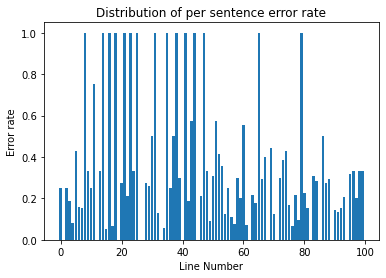

In [59]:
l_d_lists = sorted([(i, line_diffs[i]) for i in range(0, len(line_diffs))]) # sorted by key, return a list of tuples
d_lists = []
for i in range(0, len(l_d_lists)):
    t = l_d_lists[i]
    d_lists.append((t[0], t[1]))

print(d_lists)
x, y = zip(*d_lists) # unpack a list of pairs into two tuples
#plt.xticks(rotation=90)
plt.xlabel("Line Number")
plt.ylabel("Error rate")
plt.title("Distribution of per sentence error rate")
plt.bar(x, y)
plt.show()